In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/coco-2017-dataset


Running on: cuda
loading annotations into memory...
Done (t=14.71s)
creating index...
index created!
Dataset filtered to 40000 images.
Starting training with 2500 batches per epoch...


Epoch 5/5: 100%|██████████| 2500/2500 [07:08<00:00,  5.84it/s, loss=0.279]

Training Complete.


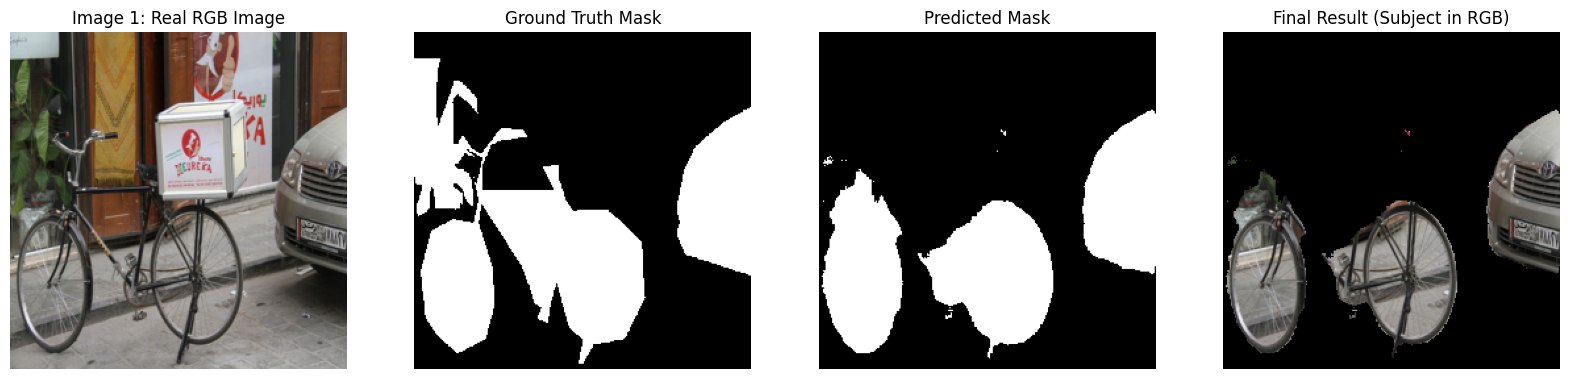

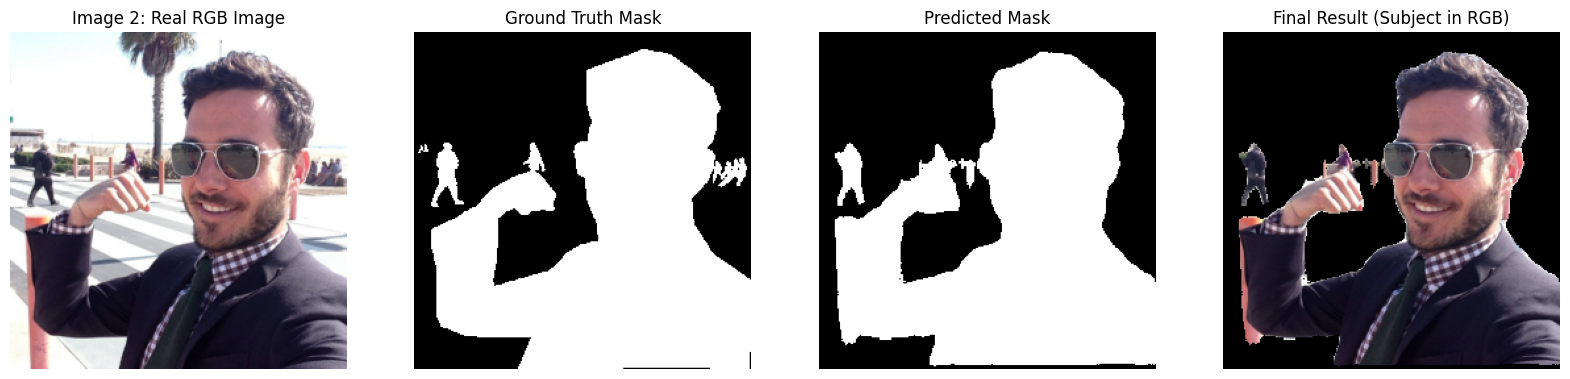

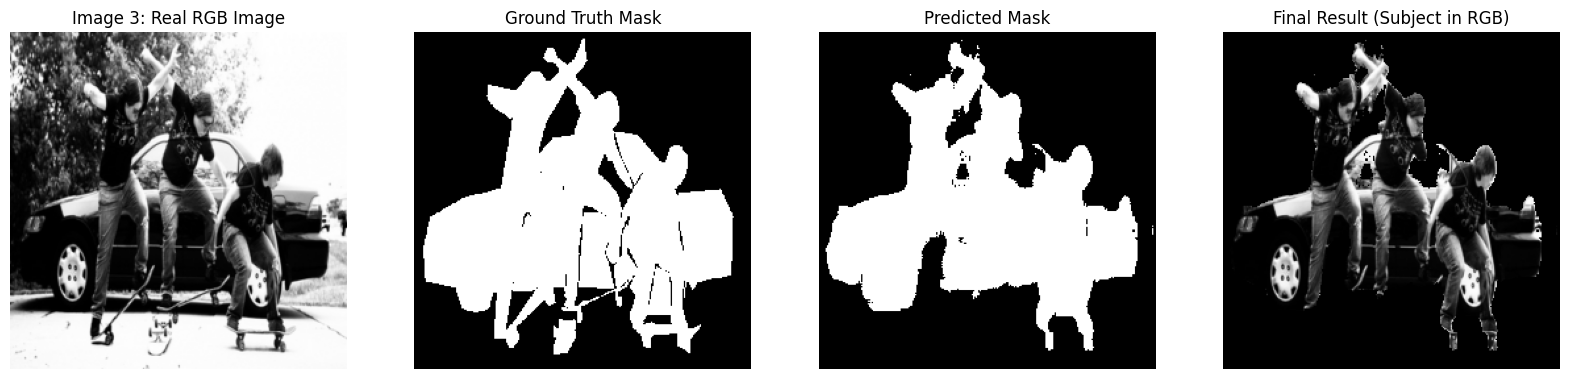

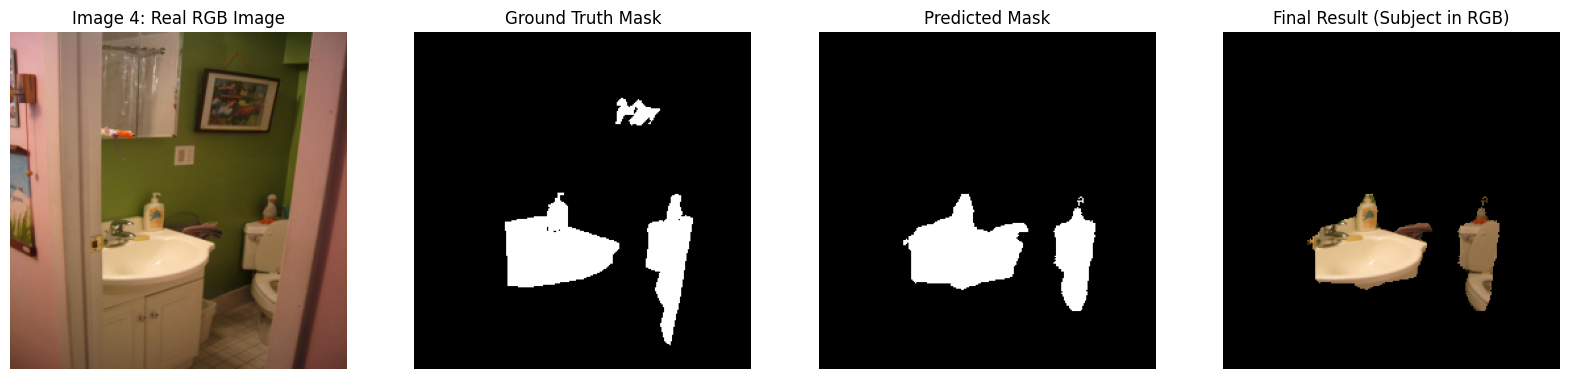

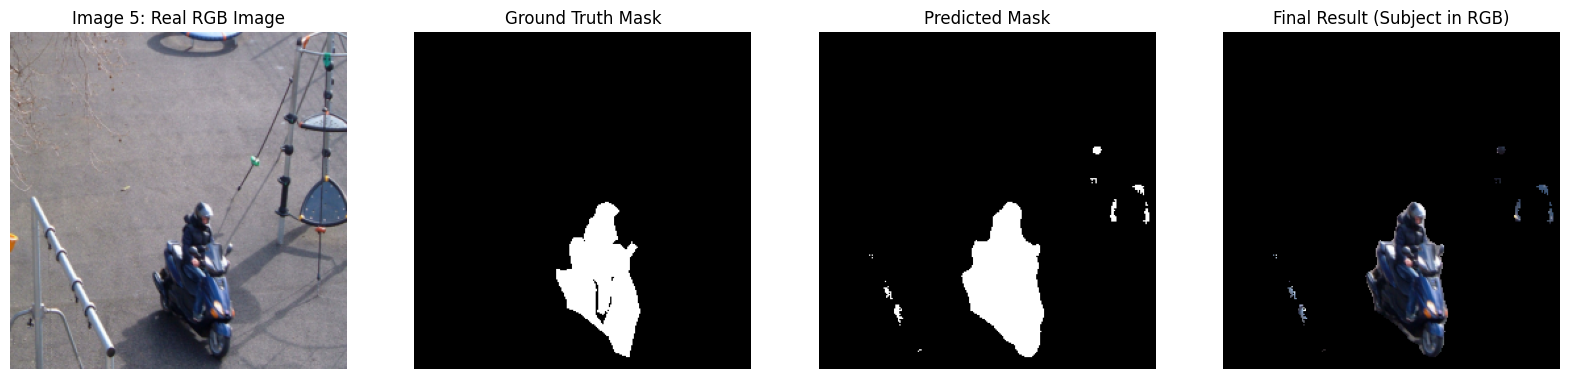

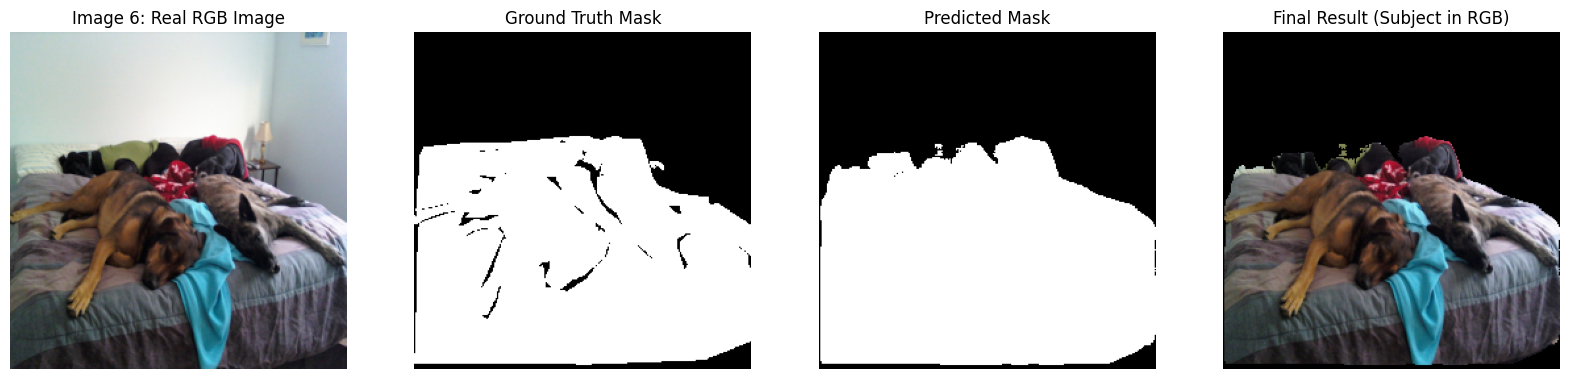

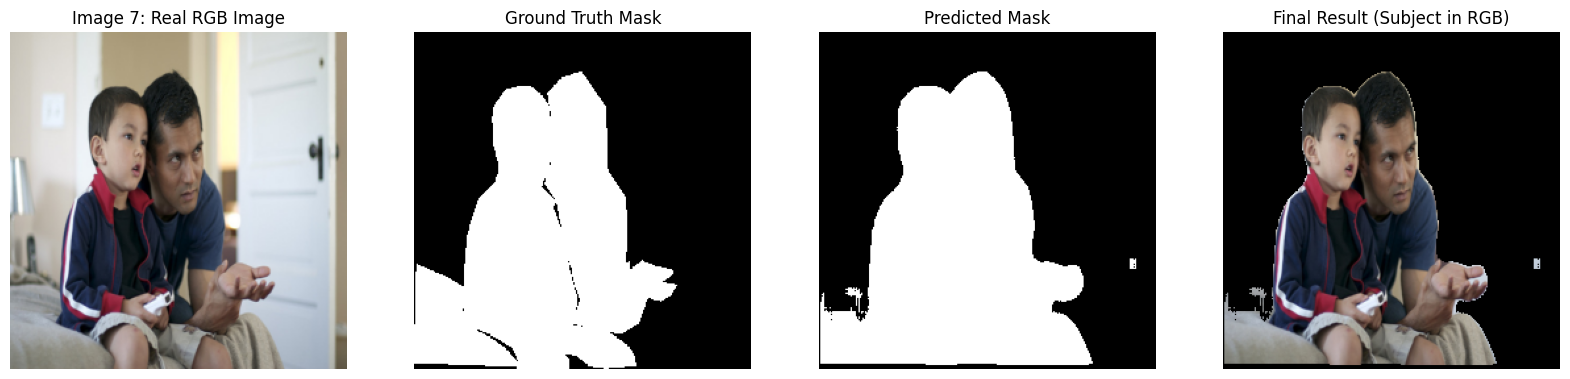

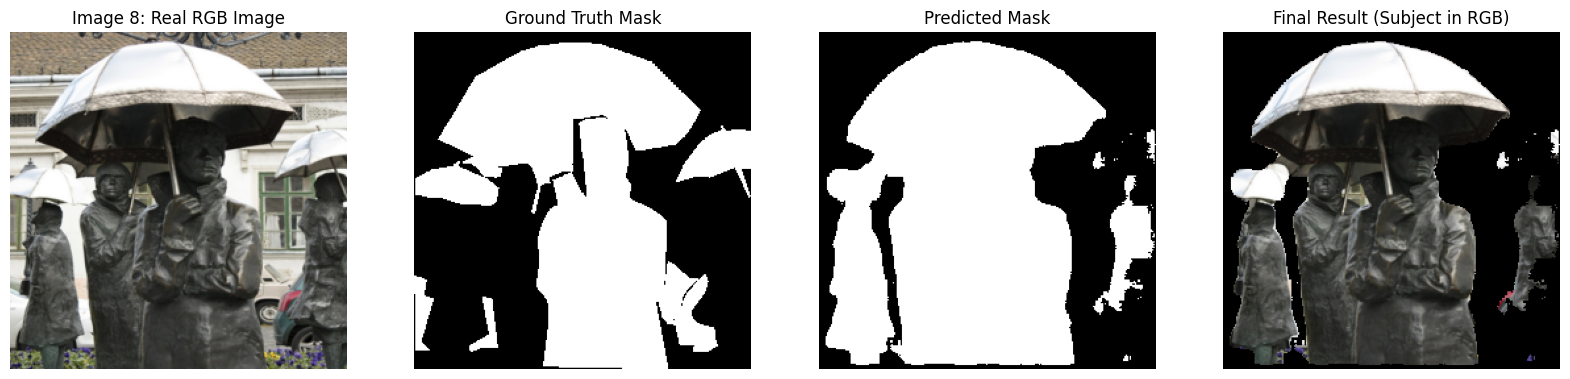

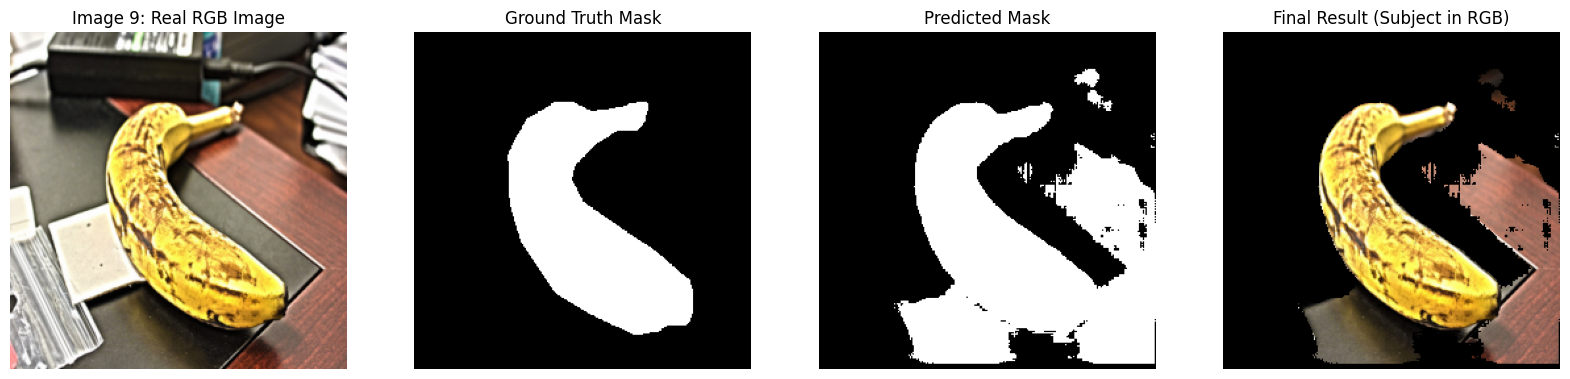

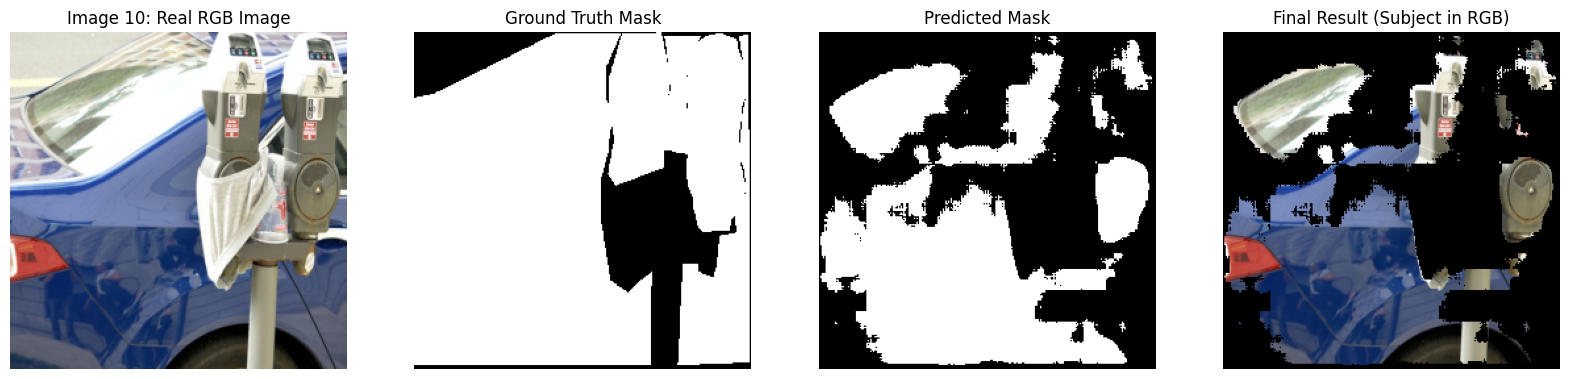

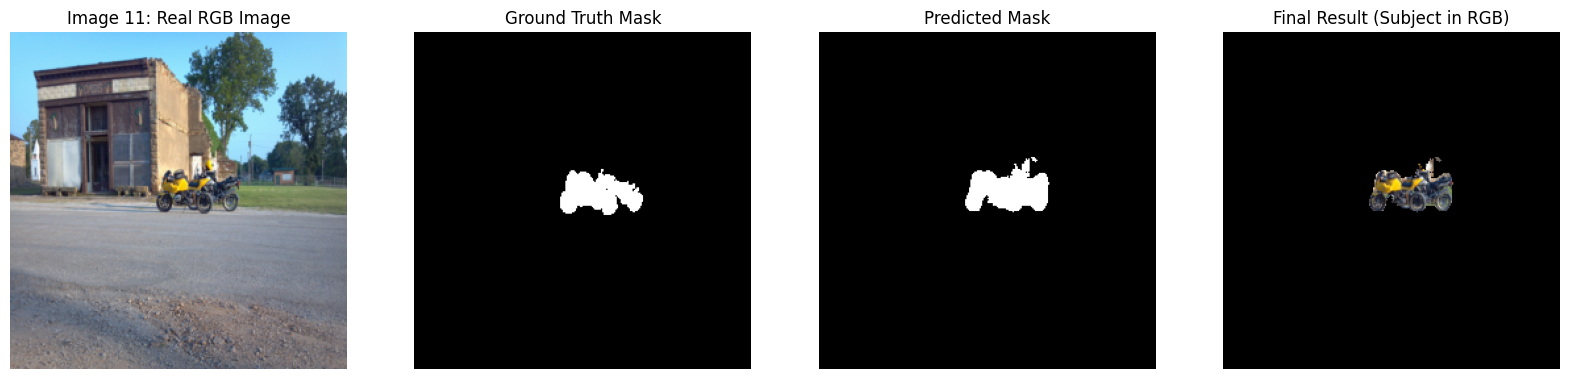

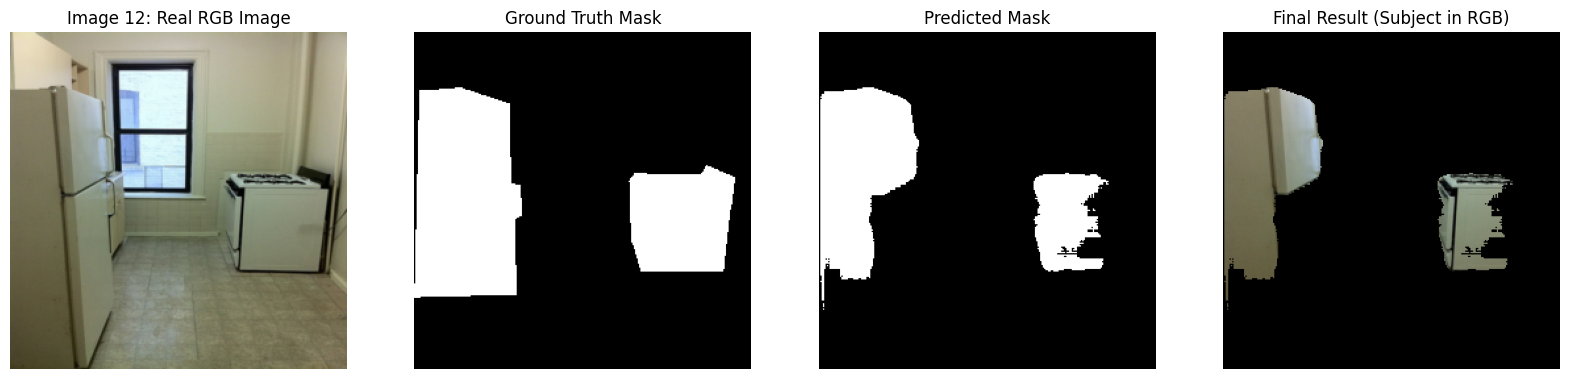

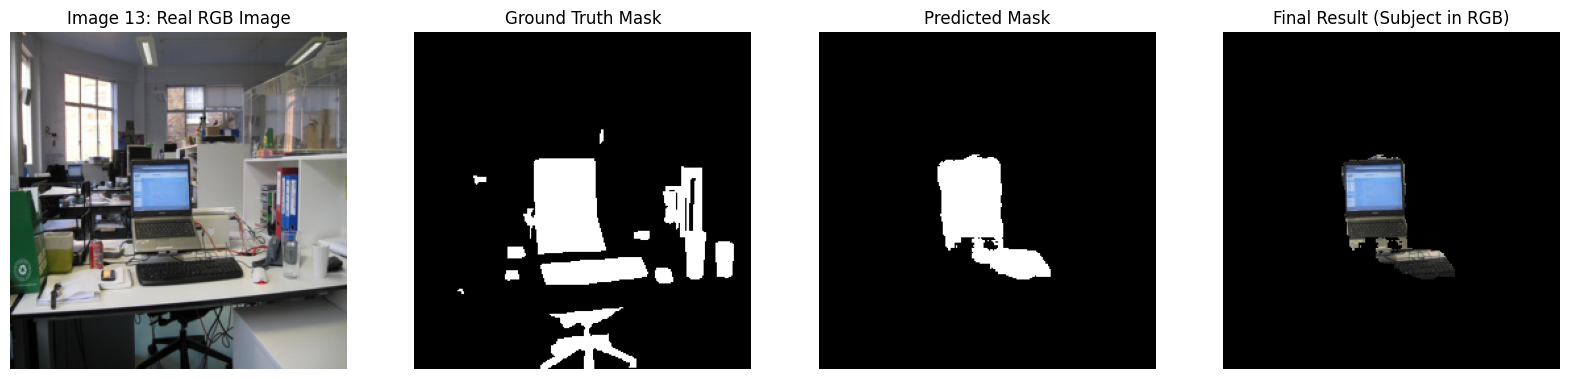

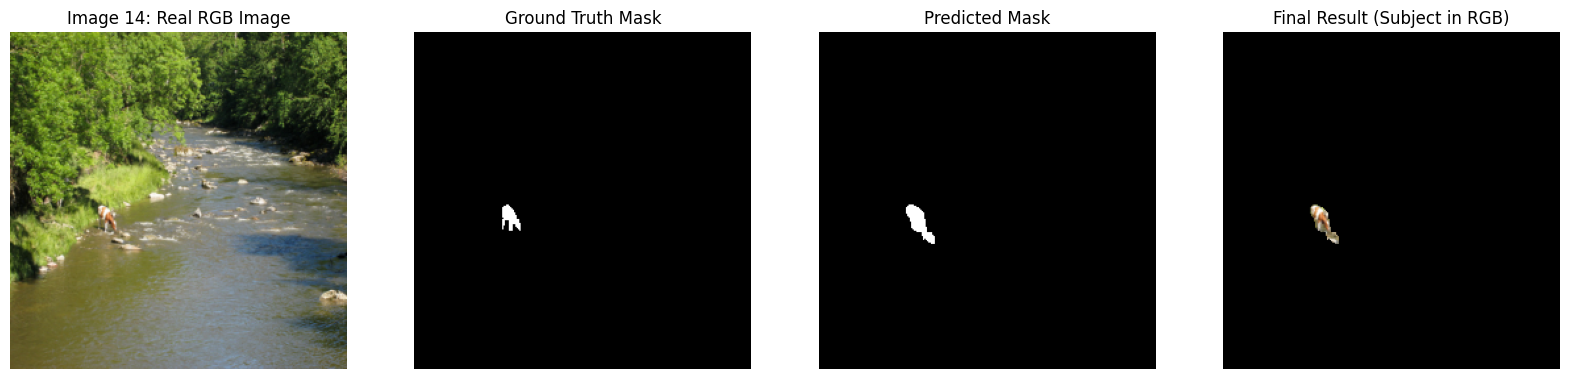

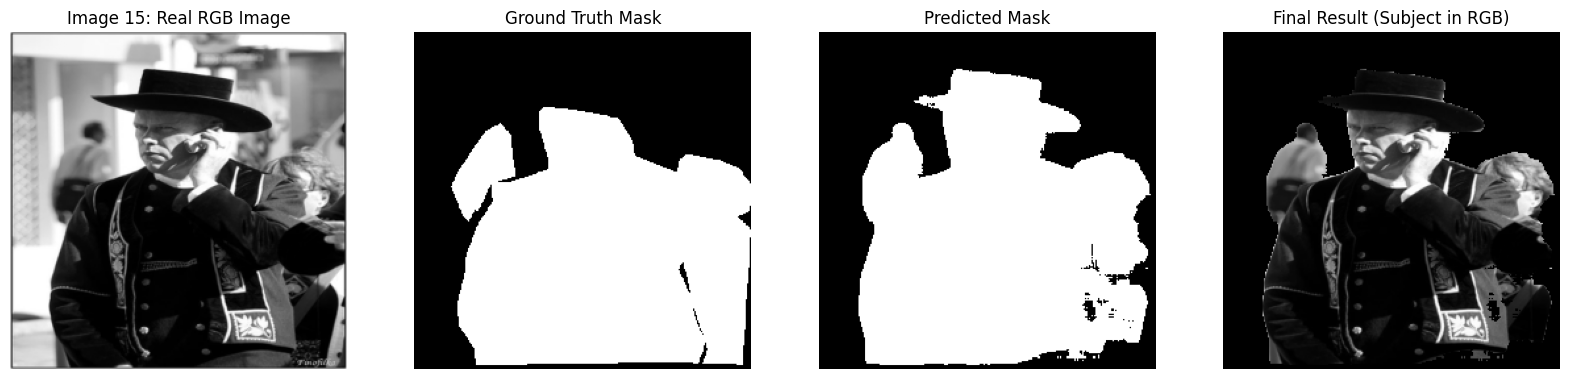

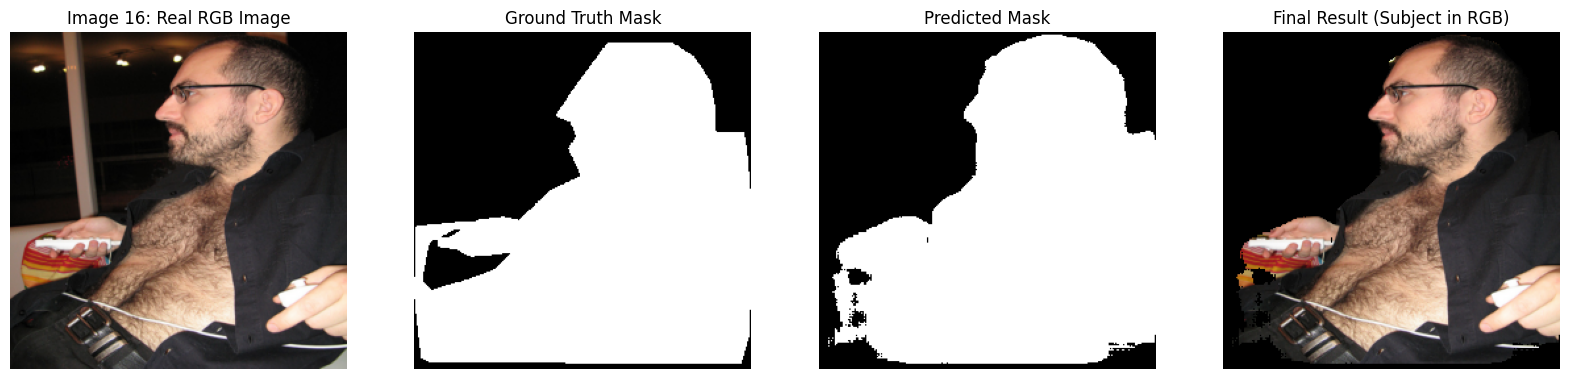

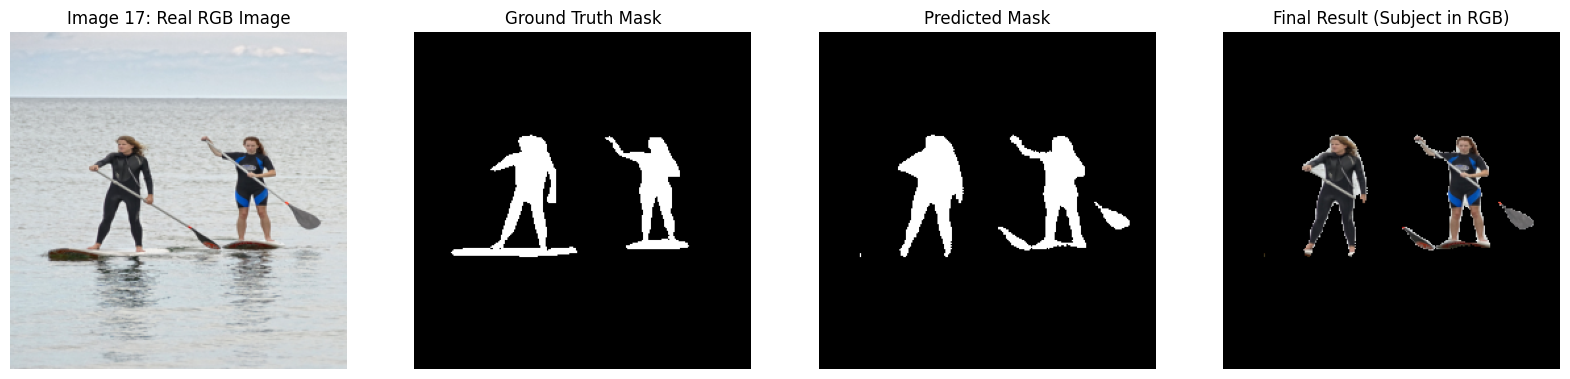

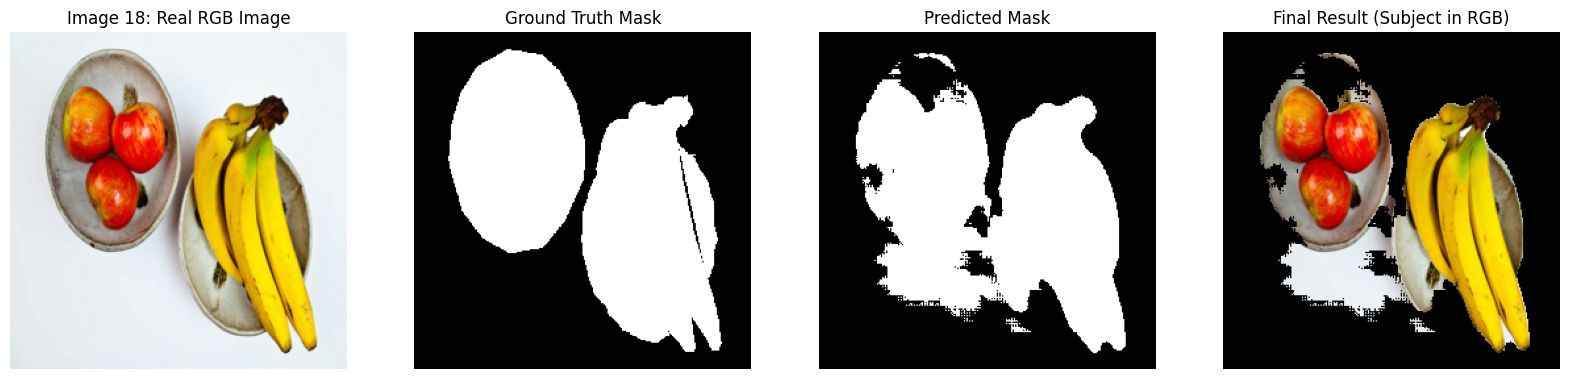

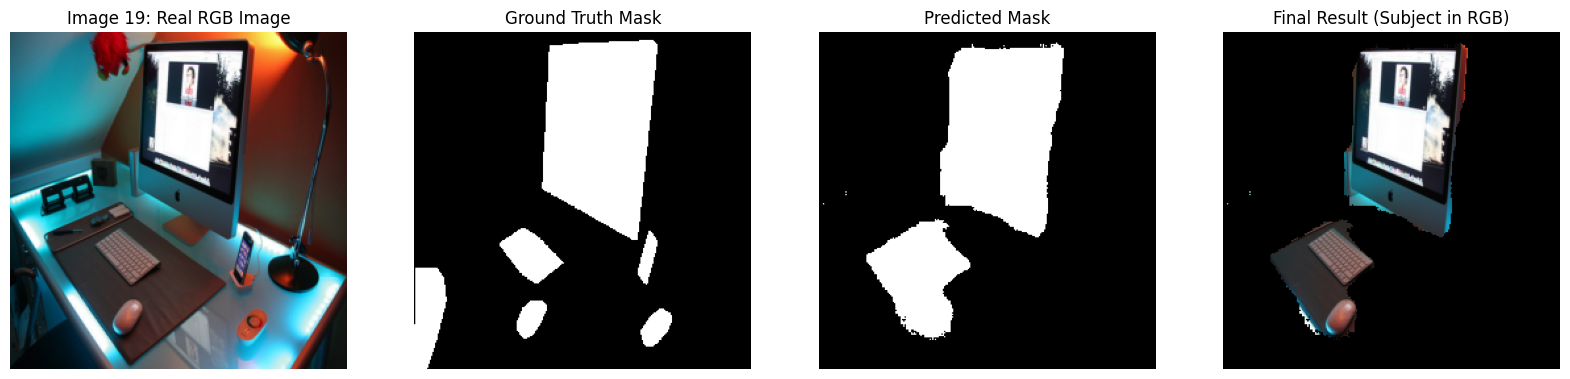

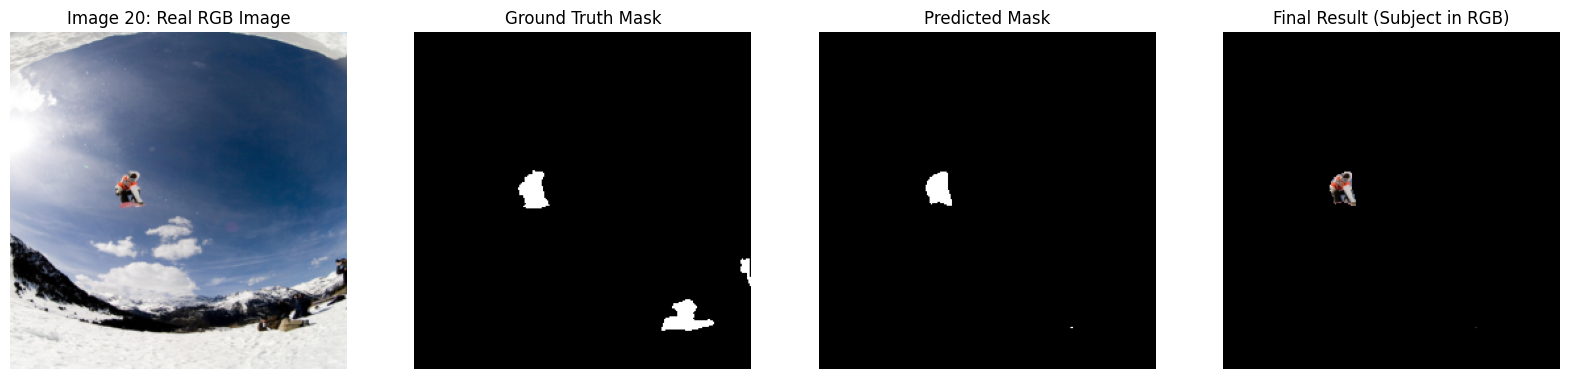

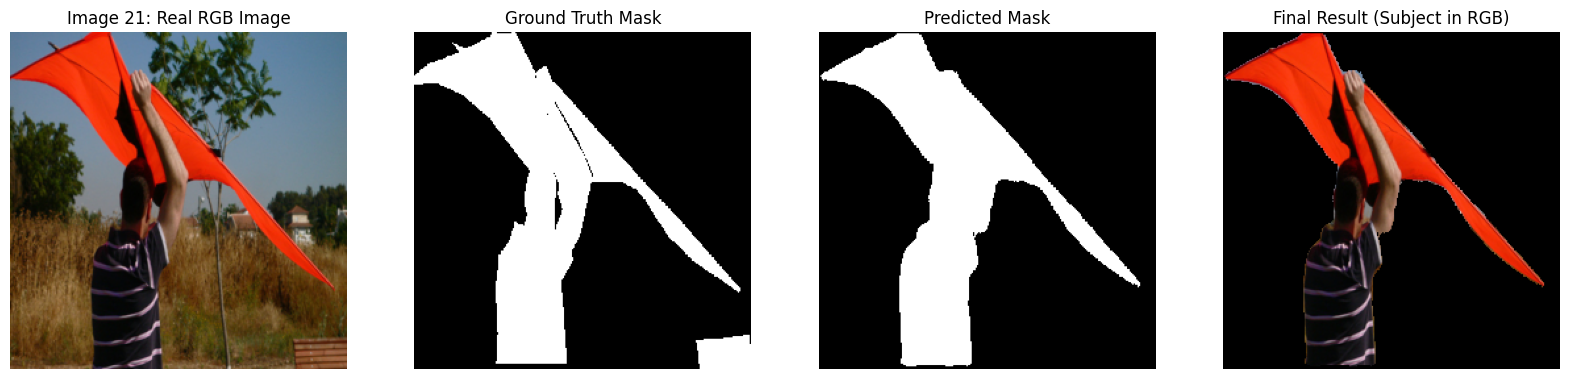

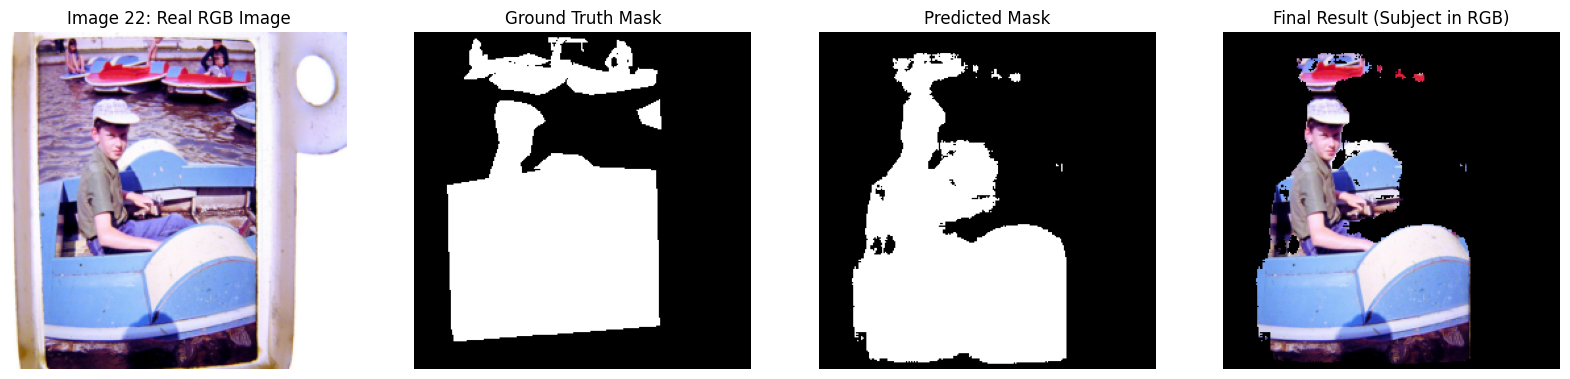

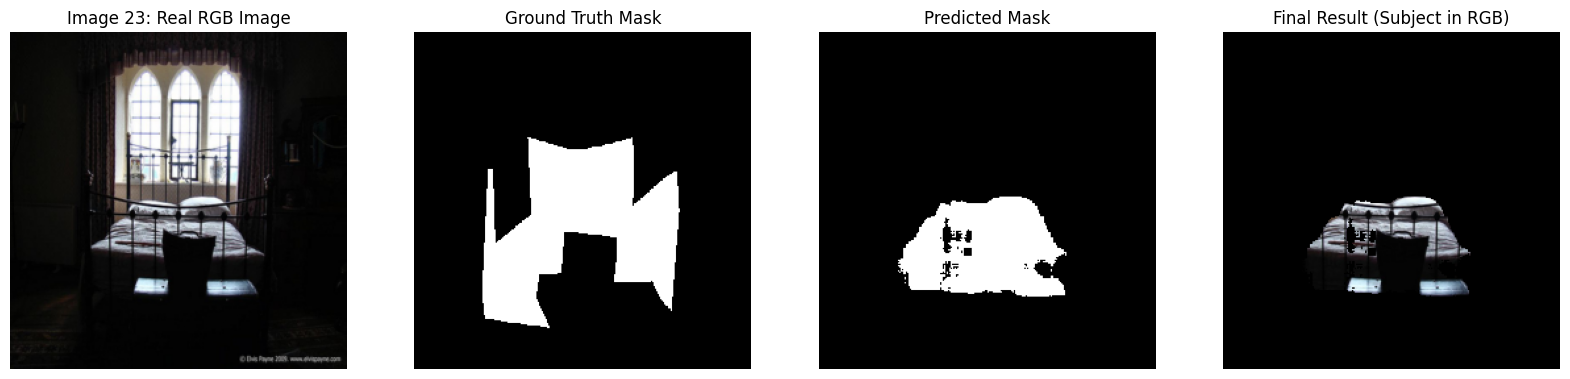

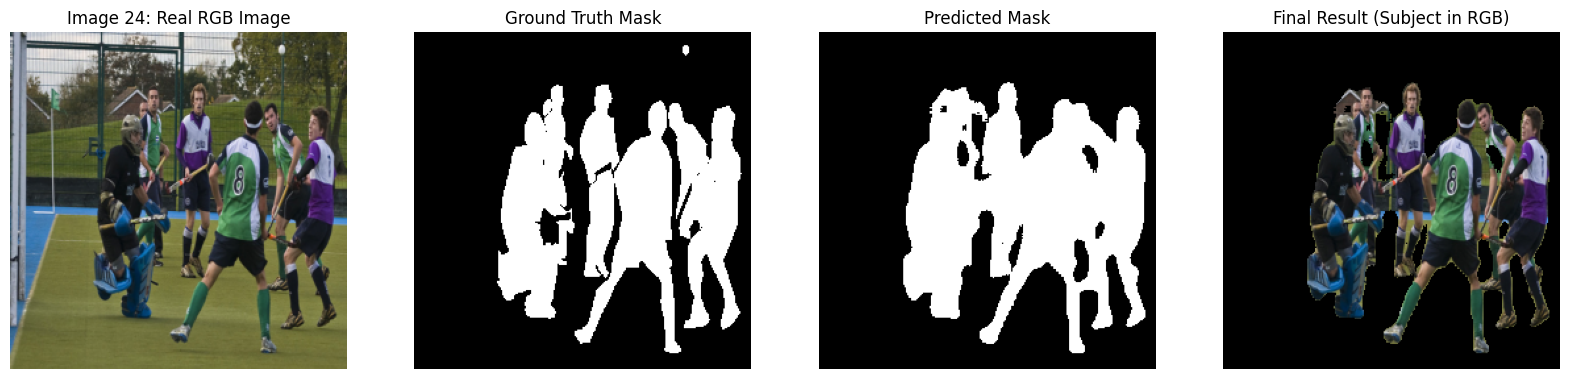

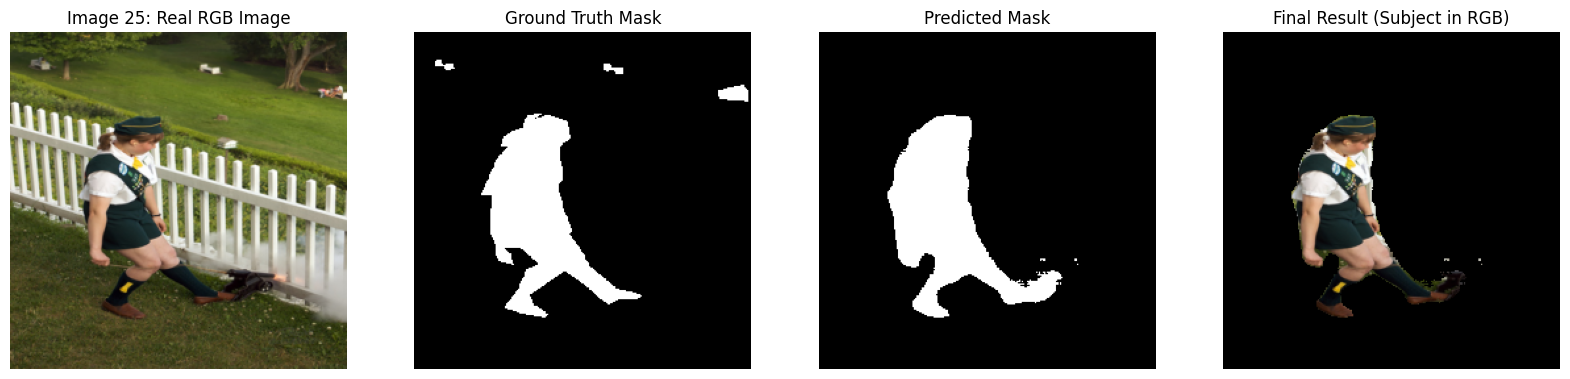

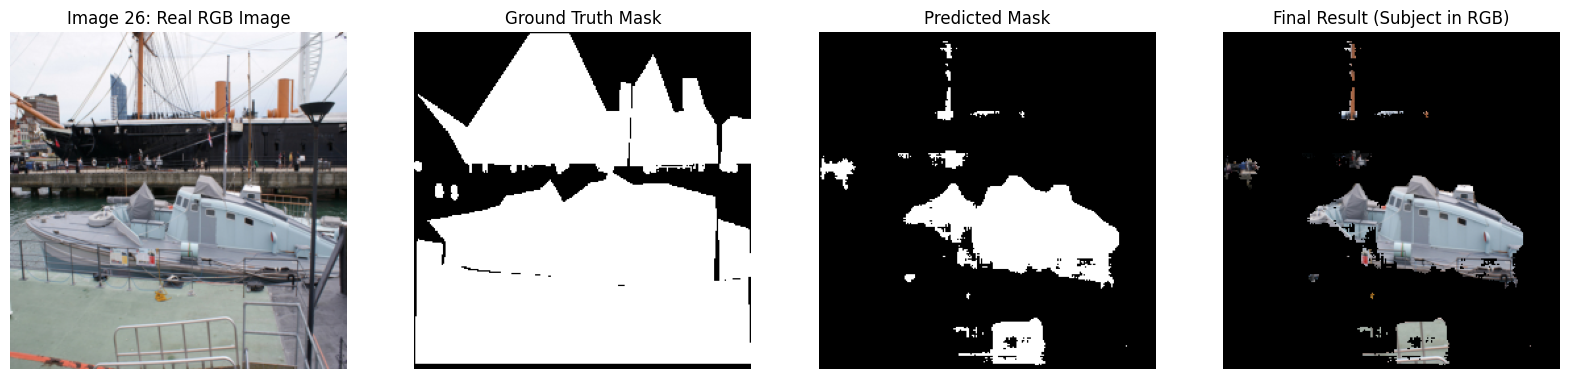

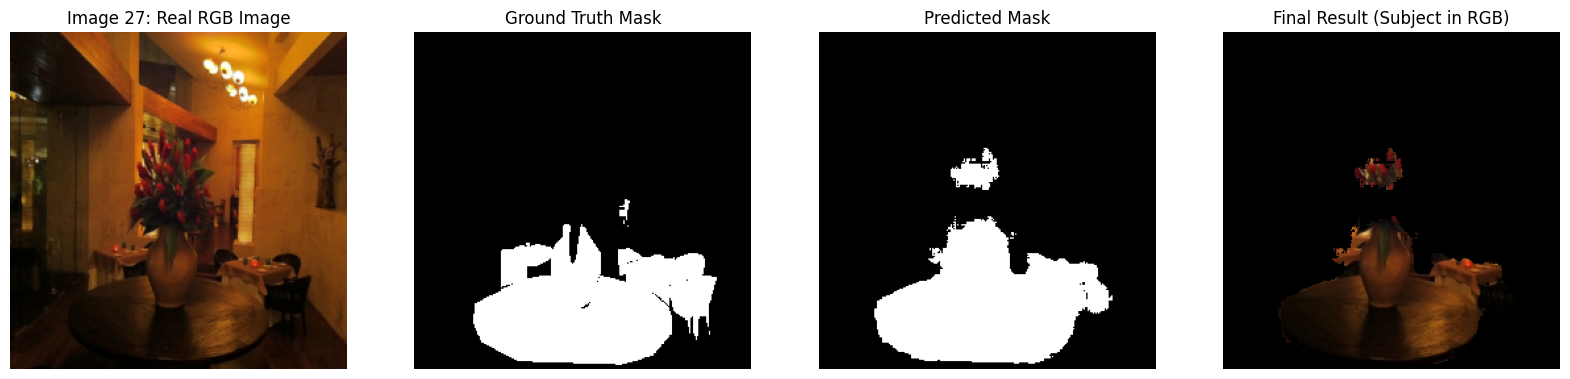

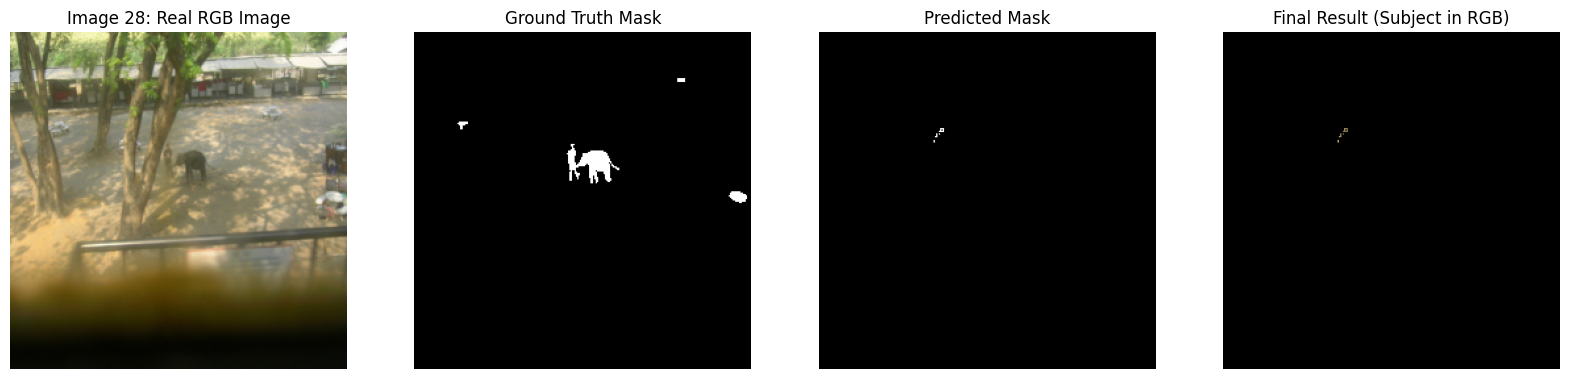

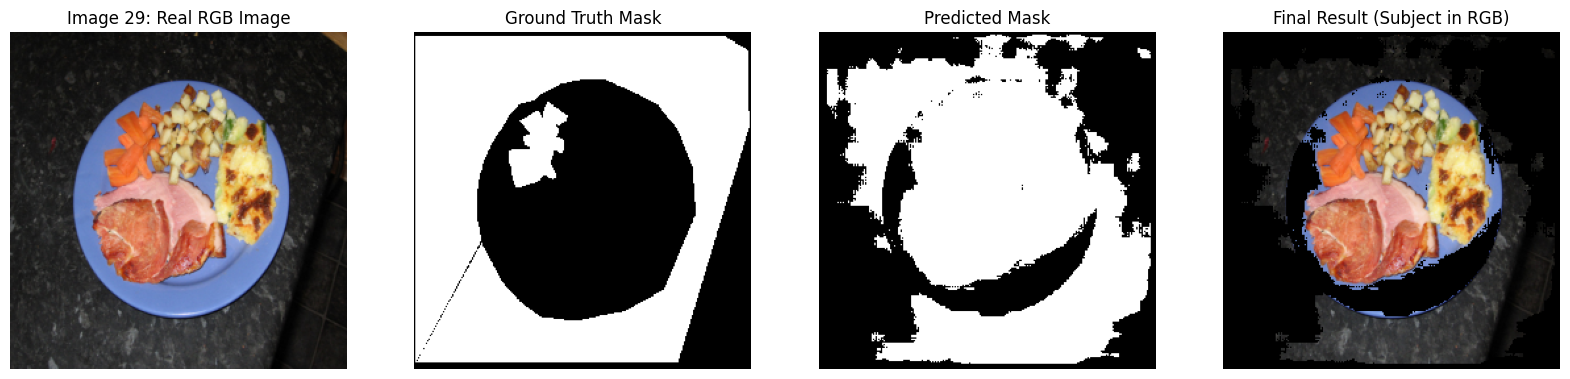

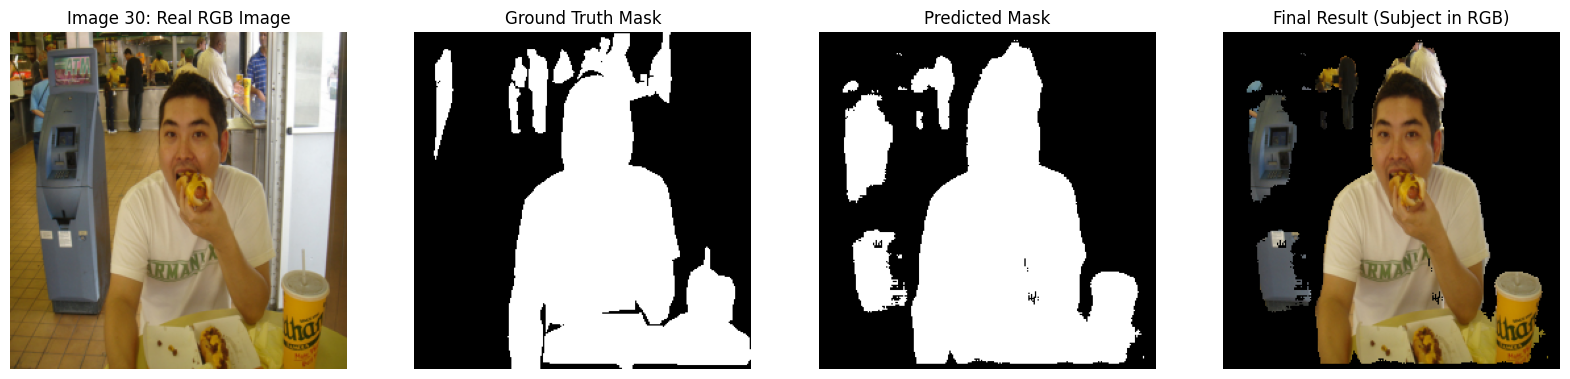

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm  # Progress bar

# --- CONFIGURATION ---
CONFIG = {
    "BATCH_SIZE": 16,
    "LR": 1e-4,
    "EPOCHS": 5,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "IMAGE_SIZE": 256,
    "NUM_IMAGES": 40000,       # Training on 40,000 images
    # CORRECT KAGGLE PATHS
    "ROOT_DIR": '/kaggle/input/coco-2017-dataset/coco2017/train2017',
    "ANN_FILE": '/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json'
}

print(f"Running on: {CONFIG['DEVICE']}")

# --- 1. DATASET CLASS ---
class COCOSegmentationDataset(Dataset):
    def __init__(self, root_dir, ann_file, transform=None, num_samples=None):
        self.root_dir = root_dir
        self.coco = COCO(ann_file)
        self.transform = transform

        # Get valid image IDs
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [img_id for img_id in self.ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]

        # Filter to 40,000 images
        if num_samples:
            self.ids = self.ids[:num_samples]
            print(f"Dataset filtered to {len(self.ids)} images.")

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_anns = coco.loadAnns(ann_ids)

        # Load Image
        img_info = coco.loadImgs(img_id)[0]
        path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(path).convert('RGB')

        # Generate Mask
        mask = np.zeros((img_info['height'], img_info['width']))
        for ann in coco_anns:
            mask = np.maximum(mask, coco.annToMask(ann))

        mask = Image.fromarray(mask * 255).convert("L")

        if self.transform:
            # Resize
            image = image.resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']), Image.BILINEAR)
            mask = mask.resize((CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']), Image.NEAREST)

            # Convert to Tensor
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

    def __len__(self):
        return len(self.ids)

# --- 2. MODEL ARCHITECTURE (FIXED DIMENSIONS) ---
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class ResNetUNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()

        # Load Pretrained Encoder
        base_model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        self.base_layers = list(base_model.children())

        # Skip Connections
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # 128x128
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # 64x64
        self.layer2 = self.base_layers[5]  # 32x32
        self.layer3 = self.base_layers[6]  # 16x16
        self.layer4 = self.base_layers[7]  # 8x8

        # Freeze Encoder
        for layer in [self.layer0, self.layer1, self.layer2, self.layer3, self.layer4]:
            for param in layer.parameters():
                param.requires_grad = False

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder4 = ConvBlock(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder3 = ConvBlock(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder2 = ConvBlock(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.decoder1 = ConvBlock(128, 64)

        # FINAL FIX: Upsample 128x128 -> 256x256
        self.final_upsample = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.final_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        # Decoder
        d4 = self.up4(x4)
        d4 = torch.cat([d4, x3], dim=1)
        d4 = self.decoder4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, x2], dim=1)
        d3 = self.decoder3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, x1], dim=1)
        d2 = self.decoder2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, x0], dim=1)
        d1 = self.decoder1(d1)

        # Final Upsample
        out = self.final_upsample(d1)

        return self.final_conv(out)

# --- 3. TRAINING FUNCTION ---
def train_model(model, loader, config):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['LR'])

    print(f"Starting training with {len(loader)} batches per epoch...")

    for epoch in range(config['EPOCHS']):
        model.train()
        epoch_loss = 0.0
        loop = tqdm(loader, desc=f"Epoch {epoch+1}/{config['EPOCHS']}")

        for batch_idx, (images, masks) in enumerate(loop):
            images = images.to(config['DEVICE'])
            masks = masks.to(config['DEVICE'])

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

    print("Training Complete.")
    return model

# --- 4. VISUALIZATION FUNCTION (Subject in RGB) ---
def visualize_results(model, loader, device, num_images_to_visualize=1):
    model.eval()
    images_displayed_count = 0

    for batch_idx, (images, masks) in enumerate(loader):
        if images_displayed_count >= num_images_to_visualize:
            break

        images = images.to(device)

        with torch.no_grad():
            preds_raw = model(images)
            preds = torch.sigmoid(preds_raw)
            preds_binary = (preds > 0.5).float()

        # Iterate through images in the current batch
        for i in range(images.shape[0]): # images.shape[0] is the batch size
            if images_displayed_count >= num_images_to_visualize:
                break

            img_tensor = images[i]
            mask_tensor = masks[i].squeeze()
            pred_tensor = preds_binary[i].squeeze()

            # Convert to Numpy
            img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) # Normalize
            mask_np = mask_tensor.cpu().numpy()
            pred_np = pred_tensor.cpu().numpy()

            # --- Create Cutoff RGB ---
            pred_mask_3d = np.dstack([pred_np, pred_np, pred_np])
            subject_rgb = img_np * pred_mask_3d

            # Plot
            plt.figure(figsize=(20, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(img_np)
            plt.title(f"Image {images_displayed_count + 1}: Real RGB Image")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(mask_np, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(pred_np, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(subject_rgb)
            plt.title("Final Result (Subject in RGB)")
            plt.axis('off')

            plt.show()
            images_displayed_count += 1

# --- 5. EXECUTION ---
if __name__ == "__main__":
    # Init Dataset
    train_dataset = COCOSegmentationDataset(
        root_dir=CONFIG['ROOT_DIR'],
        ann_file=CONFIG['ANN_FILE'],
        transform=True,
        num_samples=CONFIG['NUM_IMAGES']
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    # Init Model
    model = ResNetUNet().to(CONFIG['DEVICE'])

    # Run
    trained_model = train_model(model, train_loader, CONFIG)
    visualize_results(trained_model, train_loader, CONFIG['DEVICE'], num_images_to_visualize=30)